2018 Aug 10<br>
Now that I've figured out I've been distorting the transit by not masking it when I filter the data, I will check again how Faigler's fit (calculated by evilmc) compares to the data.

In [39]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy import units as u
from PyAstronomy.modelSuite import forTrans as ft

from evilmc import evparams, evmodel, convert_Kz
from variable_eclipses_utils import retreive_data
from transit_utils import bindata, transit_duration

In [65]:
# From Faigler+ (2013 - http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta)
semi = 1./0.221 #± 0.003
imp = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
period = 1.54492875*u.day
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s)

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*semi
Ms = 1.2*u.solMass # ± 0.2
mass_ratio = Mp.to('kg').value/Ms.to('kg').value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
logg = 4.388
m_over_H = -0.033
Omegas = vsini.to('m/s')/Rs.to('m')*period.to('s')

Ts = 6300. # ± 200

T0 = 0.68508434

Faigler_T0 = (737.49 + 2455000. - 2454833.) % period.to('day').value # ±0.19

coeffs = [0.313, 0.304]
# From https://github.com/nespinoza/limb-darkening
non_lin_coeffs = [0.37915857, 0.62585528, -0.34986866, 0.05968292]

saved_ep = evparams(per=per.to('day').value, a=a, T0=0., p=Rp_over_Rs,
                    limb_dark="quadratic", b=b, F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=mass_ratio, 
                    Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)

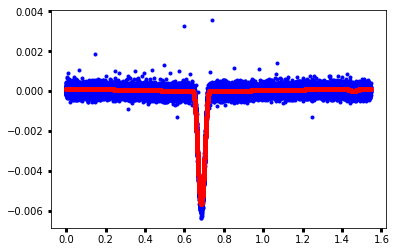

In [6]:
time, flux, filtered_time, filtered_flux = retreive_data(per.to('day').value, params=saved_ep)
folded_time = filtered_time % per.to('day').value
plt.plot(folded_time, filtered_flux, 'b.')

em = evmodel(folded_time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
sig = em.all_signals()

plt.plot(folded_time, sig, 'r.')

(0.625, 0.75)

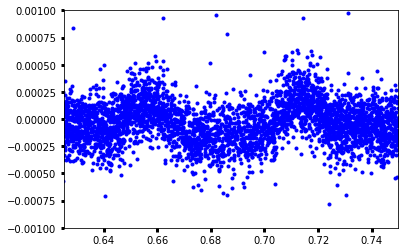

In [12]:
# Not a great fit

plt.plot(folded_time, filtered_flux - sig, 'b.')
plt.ylim([-0.001, 0.001])
plt.xlim([0.625, 0.75])

In [56]:
def fit_signal(time, T0, a, p, i, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period.to('day').value
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0]
(array([ 0.6849869 ,  5.24492264,  0.08556379, 80.08421521]), array([2.21827453e-05, 5.03671095e-02, 4.49875621e-04, 1.25991744e-01]))


(-0.002, 0.002)

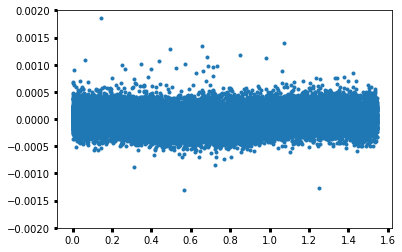

In [57]:
# Let's try with some real data
time = folded_time
flux = filtered_flux

initial_guess = [T0, semi, Rp_over_Rs, inc]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70.], [0.8, 6., 0.2, 95.]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - fit_signal(time, *popt), marker='.', ls='')
plt.ylim([-0.002, 0.002])
# plt.xlim([0.64, 0.725])

(0.64, 0.725)

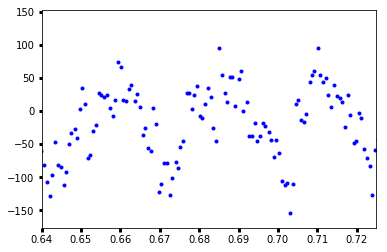

In [49]:
# Not fantastic, but decent - Let's try fitting the limb-darkening parameters?

resid = flux - fit_signal(time, *popt)
binned_time, binned_resid, binned_err = bindata(time, resid, binsize=1./60./24.)

plt.plot(binned_time, binned_resid*1e6, 'b.')
plt.xlim([0.64, 0.725])

In [52]:
def fit_signal(time, T0, a, p, i, u1, u2, supersample_factor=5, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period.to('day').value
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = u1
    model["quadLimb"] = u2
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

[0.68508434, 4.524886877828054, 0.09683257918552035, 78.0, 0.313, 0.304]
(array([ 0.68498892,  5.24329189,  0.08787176, 80.16558656,  0.29950668,
        0.53278529]), array([2.64051822e-05, 1.14176725e+00, 3.22433239e-02, 2.62705460e+00,
       6.09252502e+00, 6.46569178e+00]))


(-0.001, 0.001)

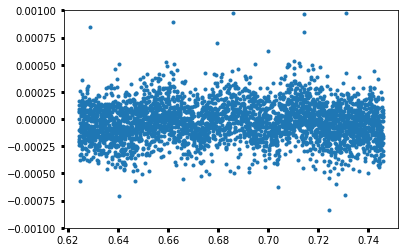

In [53]:
# Focus on just the transit
dur = transit_duration(saved_ep)
ind = np.abs(folded_time - T0) <= dur

time = folded_time[ind]
flux = filtered_flux[ind]

initial_guess = [T0, semi, Rp_over_Rs, inc, coeffs[0], coeffs[1]]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess,
                       bounds=([0.6, 2., 0., 70., 0., 0.], [0.8, 6., 0.2, 95., 1., 1.]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - fit_signal(time, *popt), marker='.', ls='')
plt.ylim([-0.001, 0.001])
# plt.xlim([0.64, 0.725])

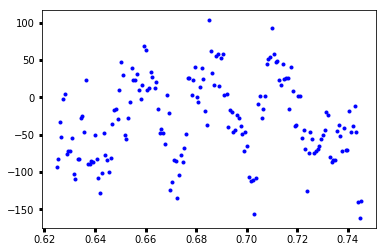

In [54]:
resid = flux - fit_signal(time, *popt)
binned_time, binned_resid, binned_err = bindata(time, resid, binsize=1./60./24.)

plt.plot(binned_time, binned_resid*1e6, 'b.')

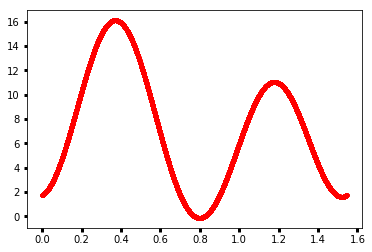

In [66]:
# OK, let's try to subtract off all the other variations except the transit and then fit what's left

time = folded_time
flux = filtered_flux

em = evmodel(time, saved_ep, supersample_factor=5, exp_time=30./60./24.)
sig = em.evilmc_signal()

#plt.plot(time, flux, 'b.')
plt.plot(folded_time, sig*1e6, 'r.')